In [1]:
## imports
import pandas as pd
import numpy as np
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC


import warnings
warnings.filterwarnings("ignore")

In [2]:
## Research Goal
# Predicting survival with various classifiers and comparing the results



In [3]:
## Retrieving the data

data = pd.read_csv("train.csv")

In [4]:
## Data Exploration and preparation
# Both these will be performed simultaneously for better presenting, we will explore characteristic and resolve 1 at a time.
data.info()
data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# From above
# we can safely drop non contributing columns 
# for assurity our guess is that PassengerID (unique), Name (unique), Ticket(unique), SibSp (biased), 
# Parch (biased) are non contributing. Let's get info on them
for col in ['PassengerId','Name', 'Ticket', 'Parch', 'SibSp']:
    print()
    print(col)
    print(data[col].value_counts())
    print(data[col].describe())


PassengerId
891    1
293    1
304    1
303    1
302    1
      ..
591    1
590    1
589    1
588    1
1      1
Name: PassengerId, Length: 891, dtype: int64
count    891.000000
mean     446.000000
std      257.353842
min        1.000000
25%      223.500000
50%      446.000000
75%      668.500000
max      891.000000
Name: PassengerId, dtype: float64

Name
Behr, Mr. Karl Howell                  1
Hakkarainen, Mr. Pekka Pietari         1
Salonen, Mr. Johan Werner              1
Dakic, Mr. Branko                      1
Kink-Heilmann, Miss. Luise Gretchen    1
                                      ..
Sdycoff, Mr. Todor                     1
Nasser, Mr. Nicholas                   1
Andersson, Miss. Erna Alexandra        1
Walker, Mr. William Anderson           1
Goncalves, Mr. Manuel Estanslas        1
Name: Name, Length: 891, dtype: int64
count                       891
unique                      891
top       Behr, Mr. Karl Howell
freq                          1
Name: Name, dtype: object


In [6]:
# From above, Name and PassengerID are 100% unique so we can drop them
# Ticket, even though lesser than above still has about 75% unique values hence not very useful either
# SibSp and Parch ID as per the guess are very biased however not enough for them to be dropped
data = data.drop(['PassengerId','Name', 'Ticket'], axis=1)
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(3)
memory usage: 62.8+ KB


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


In [7]:
# cabin is mostly null so we should remove it
data = data.drop(['Cabin'], axis=1)

# Age is somewhat null so we should fill it with the existing values in the distribution
mean = data["Age"].mean()
std = data["Age"].std()
# we will randomly generate ages in the standard width
random_ages = [random.randrange(int(mean - std), int(mean + std)) for _ in range(data["Age"].isna().sum())]
# replace the null with a random age 1 at a time
for age in random_ages:
    data["Age"].fillna(age, inplace = True, limit=1)
# finally converting age to int
data["Age"] = data["Age"].astype(int)

# also converting Fare to int
data['Fare'] = data['Fare'].astype(int)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null object
Age         891 non-null int64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null int64
Embarked    889 non-null object
dtypes: int64(6), object(2)
memory usage: 55.8+ KB


In [8]:
print(data["Embarked"].value_counts())
data["Embarked"].describe()

S    644
C    168
Q     77
Name: Embarked, dtype: int64


count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [9]:
# Embarked has neglible null entries so we can just fill with the top value
data["Embarked"].fillna(data["Embarked"].describe().top, inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null object
Age         891 non-null int64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null int64
Embarked    891 non-null object
dtypes: int64(6), object(2)
memory usage: 55.8+ KB


In [10]:
# Converting remaining columns to int
sex_mapper = {val:i for i,val in enumerate(data.Sex.unique())}
data["Sex"] = data["Sex"].map(sex_mapper)

embarked_mapper = {val:i for i,val in enumerate(data.Embarked.unique())}
data["Embarked"] = data["Embarked"].map(embarked_mapper)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null int64
Age         891 non-null int64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null int64
Embarked    891 non-null int64
dtypes: int64(8)
memory usage: 55.8 KB


In [11]:
# Data Modelling
train, test = train_test_split(data, test_size=0.25)
X_test = test.drop("Survived", axis=1)
X_train = train.drop("Survived", axis=1)
Y_train = train["Survived"]
Y_true = np.array(test["Survived"])

In [12]:
models_mapper = {RandomForestClassifier: "Random Forest", KNeighborsClassifier: "KNN", SVC: "SVC", 
                 LinearSVC: "Linear SVC", GaussianNB: "Gaussian NB", LogisticRegression: "Logistic Regression", 
                 DecisionTreeClassifier: "Decision Tree"}

results = dict()
for model,model_name in models_mapper.items():
    mod = model()
    mod.fit(X_train, Y_train)

    Y_predicted = mod.predict(X_test)
    results[model_name] = {
    "Coefficient of \ndetermination \nR^2": mod.score(X_train, Y_train),
    "Accuracy":accuracy_score(Y_true, Y_predicted),
    "Recall":recall_score(Y_true, Y_predicted),
    "Precision": precision_score(Y_true, Y_predicted, average='macro'),
    "F1 Score":f1_score(Y_true, Y_predicted, average='macro')}
    


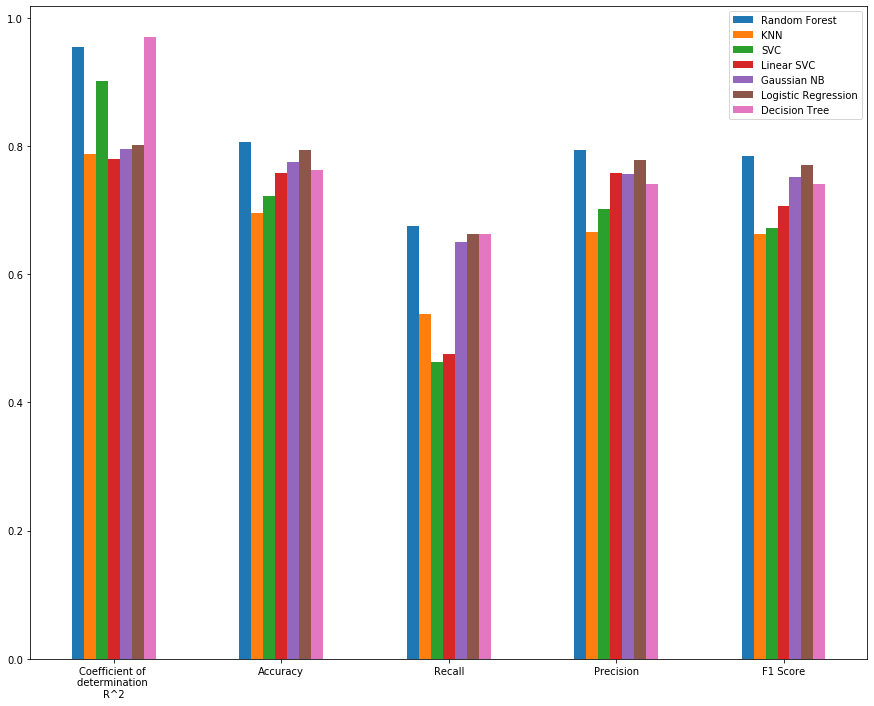

In [14]:
# Presentation
results = pd.DataFrame(results)
results.plot(kind='bar', figsize=(15,12),rot=0)